In [1]:
import optuna
import logging
import warnings

import warnings
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler("./cache/optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

base_path = './prod/filtered'

def get_study(name):
    # create or load the study
    study = optuna.study.create_study(
        storage=f'sqlite:///{base_path}/cache/optuna.db',
        load_if_exists=True,
        directions=['maximize', 'minimize'],
        study_name=name,
        sampler=optuna.samplers.TPESampler(n_startup_trials=150),
        pruner=optuna.pruners.MedianPruner()
    )
    study.set_metric_names(['r2', 'mse'])
    return study


/home/marco/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Set sklearn output to pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')

# Select Variables

Mean before subsampling: 7.86109599611841
Mean after subsampling: 16.03297287402342


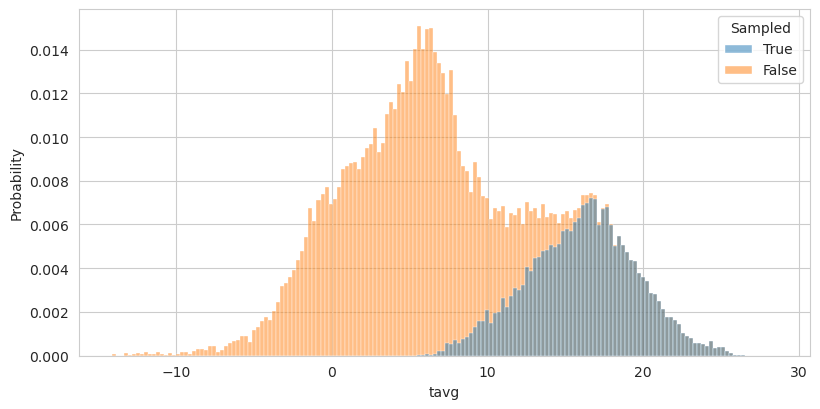

In [23]:
from src.selectvar import get_data

data, variables = get_data(window=7)
print(f'Mean before subsampling: {data["tavg"].mean()}')

weather_total = data[['tavg']].copy()
weather_total['Sampled'] = 'False'

# Filter data
data = data[(data['pmonin'] <= 9) & (data['pmonin'] >= 5)].copy()
print(f'Mean after subsampling: {data["tavg"].mean()}')

weather_ss = data[['tavg']].copy()
weather_ss['Sampled'] = 'True'
weather = pd.concat([weather_ss, weather_total], axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(8.3, 4.2))
sns.histplot(weather, x='tavg', hue='Sampled', stat='probability', ax=ax)
plt.tight_layout()
plt.savefig(f'{base_path}/plots/temperature_distribution.pdf', dpi=300)

In [65]:
# interpolate
data.sort_values(by=['pid', 'syear'], inplace=True)
data = data.groupby('pid').bfill(1).reset_index(names='pid')

In [66]:
def remove_duplicate_prefixes(strings):
    selected_strings = []
    removed_strings = []
    seen_prefixes = set()
    for string in strings:
        prefix = string.split('_')[0]
        if prefix not in seen_prefixes:
            seen_prefixes.add(prefix)
            selected_strings.append(string)
        else:
            removed_strings.append(string)
    return removed_strings

def get_category(cat):
    return variables.loc['category', variables.loc['category',:] == cat].index.tolist()

def get_type(typ):
    return variables.loc['type', variables.loc['type',:] == typ].index.tolist()

# Manuall dropping of variables (very clear cases)
columns_to_drop = [
    'fweight', 'fheight', 'valid', # imputation flags
    'pcs', 'mcs', #pca of other variables
    'plj0151'
]
columns_to_drop += get_category('key')
columns_to_drop += remove_duplicate_prefixes(data.columns)

data.drop(columns=columns_to_drop, inplace=True)
variables.drop(columns=columns_to_drop, inplace=True)

# drop nans
data[data<0] = np.nan

# get target
variables.drop(columns='plh0182', inplace=True)
y = data.pop('plh0182')

print(f'There are {data.shape[0]} rows in the data')

There are 156492 rows in the data


In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# do pca transform for all categories
transformers = []

for typ in tqdm(variables.loc['type',:].unique()):
    # Get subset of data in that category
    vars = get_type(typ)

    if typ == 'Nominal':
        vars_keep = [v for v in vars if len(data.loc[:,v].unique()) < 20]
        transformers.append((typ, OneHotEncoder(sparse_output=False), vars_keep))
        vars_drop = [v for v in vars if len(data.loc[:,v].unique()) >= 20]
        transformers.append(('High Cardinality', 'drop', vars_drop))
    elif typ == 'Ordinal':
        transformers.append((typ, StandardScaler(), vars))
    elif typ == 'Discrete':
        transformers.append((typ, StandardScaler(), vars))
    else:
        transformers.append((typ, StandardScaler(), vars))
transformers.append(('Weather', StandardScaler(), ['prcp', 'tsun', 'wspd', 'pres', 'tavg']))

100%|██████████| 4/4 [00:00<00:00, 55.83it/s]


In [68]:
from sklearn.compose import ColumnTransformer

# define the transformers
transformer = ColumnTransformer(
    transformers, remainder='drop'
)

transformer.fit(data)
X = transformer.transform(data)

# only take selected variables
selected_variables = [
    'Continuous__gh_nbs', 'Continuous__mh_nbs',
    'Continuous__pli0044_h', 'Continuous__re_nbs',
    'Continuous__rp_nbs', 'Continuous__sf_nbs', 'Continuous__vt_nbs',
    'Discrete__ple0010_h', 'Discrete__syear', 'Nominal__hlk0056_9.0',
    'Nominal__pla0009_v2_1.0', 'Nominal__pld0131_v1_1.0',
    'Ordinal__ple0008', 'Ordinal__plh0033', 'Ordinal__plh0171',
    'Ordinal__plh0175', 'Ordinal__plh0177', 'Ordinal__plh0178',
    'Weather__prcp', 'Weather__tsun', 'Weather__wspd', 
    'Weather__pres', 'Weather__tavg'
]

X = X.loc[:, selected_variables].copy()
X['target'] = y
X.dropna(inplace=True)
y = X.pop('target')
print(f'There are {X.shape[0]} rows remaining in the data.')

There are 50422 rows remaining in the data.


In [69]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [70]:
from sklearn.model_selection import StratifiedKFold

custom_cv = StratifiedKFold(n_splits=5, shuffle=True)

In [57]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Objective function for hp tuning
def objective(trial, est, suggestor):
    # suggest params
    params = suggestor(trial)
    est.set_params(**params)
    # suggest number of principle components
    r2_scores, mse_scores = [], []
    for train_idx, test_idx in custom_cv.split(X_train, y_train):
        # fit estimator
        est = est.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        # predict test set
        y_pred = est.predict(X_train.iloc[test_idx])
        y_true = y_train.iloc[test_idx]
        # compute the performance
        r2_scores.append(r2_score(y_true, y_pred))
        mse_scores.append(mean_squared_error(y_true, y_pred))
    return np.mean(r2_scores), np.mean(mse_scores)

############################
############################

# Suggesting functions for each model
def hb_suggestor(t):
    t.suggest_int('max_iter', 1, 1001, 10)
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 10, 400, step=10)
    t.suggest_float('l2_regularization', 0.001, 100, log=True)
    return t.params

def sgd_suggestor(t):
    t.suggest_float('alpha', 1e-4, 1e-1, log=True)
    t.suggest_float('epsilon', 1e-2, 0.1)
    t.suggest_categorical('loss', ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error', 'huber'])
    t.suggest_categorical('penalty', ["l2", "l1", "elasticnet"])
    return t.params

def rf_suggestor(t):
    t.suggest_int('max_depth', 1, 40, 1)
    t.suggest_int('min_samples_split', 10, 500, 10)
    t.suggest_int('min_samples_leaf', 10, 500, 10)
    t.suggest_float('max_features', 0.001, 1)
    return t.params

############################
############################

# Define the models to optimize
hb = HistGradientBoostingRegressor(
    learning_rate=0.01, early_stopping=True
)
sgd = SGDRegressor(max_iter=20_000)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, bootstrap=True)

models = [
    ('Random Forest Regressor', rf, rf_suggestor),
    ('Hist Gradient Boosting Regressor', hb, hb_suggestor),
    ('Stochastic Gradient Descent', sgd, sgd_suggestor)
]

for name, model, func in models:
    study = get_study(name)
    study.optimize(lambda x: objective(x, model, func), timeout=60*60, n_trials=250)

In [71]:
# Set best parameters
rf_best_param = {
    'max_depth': 20, 
    'max_features': 0.49016545328946043, 
    'min_samples_leaf': 10, 
    'min_samples_split': 30
}
rf.set_params(**rf_best_param)
rf.fit(X_train, y_train)

hb_best_param = {
    'l2_regularization':0.0177290899656223,
    'max_depth':16,
    'max_iter':1001,
    'min_samples_leaf':30
}
hb.set_params(**hb_best_param)
hb.fit(X_train, y_train)

sgd_best_param = {
    'alpha':0.002739861711012022,
    'epsilon':0.03386830013397616,
    'loss':'squared_error',
    'penalty':'elasticnet'
}
sgd.set_params(**sgd_best_param)
sgd.fit(X_train, y_train)

SGDRegressor(alpha=0.002739861711012022, epsilon=0.03386830013397616,
             max_iter=20000, penalty='elasticnet')

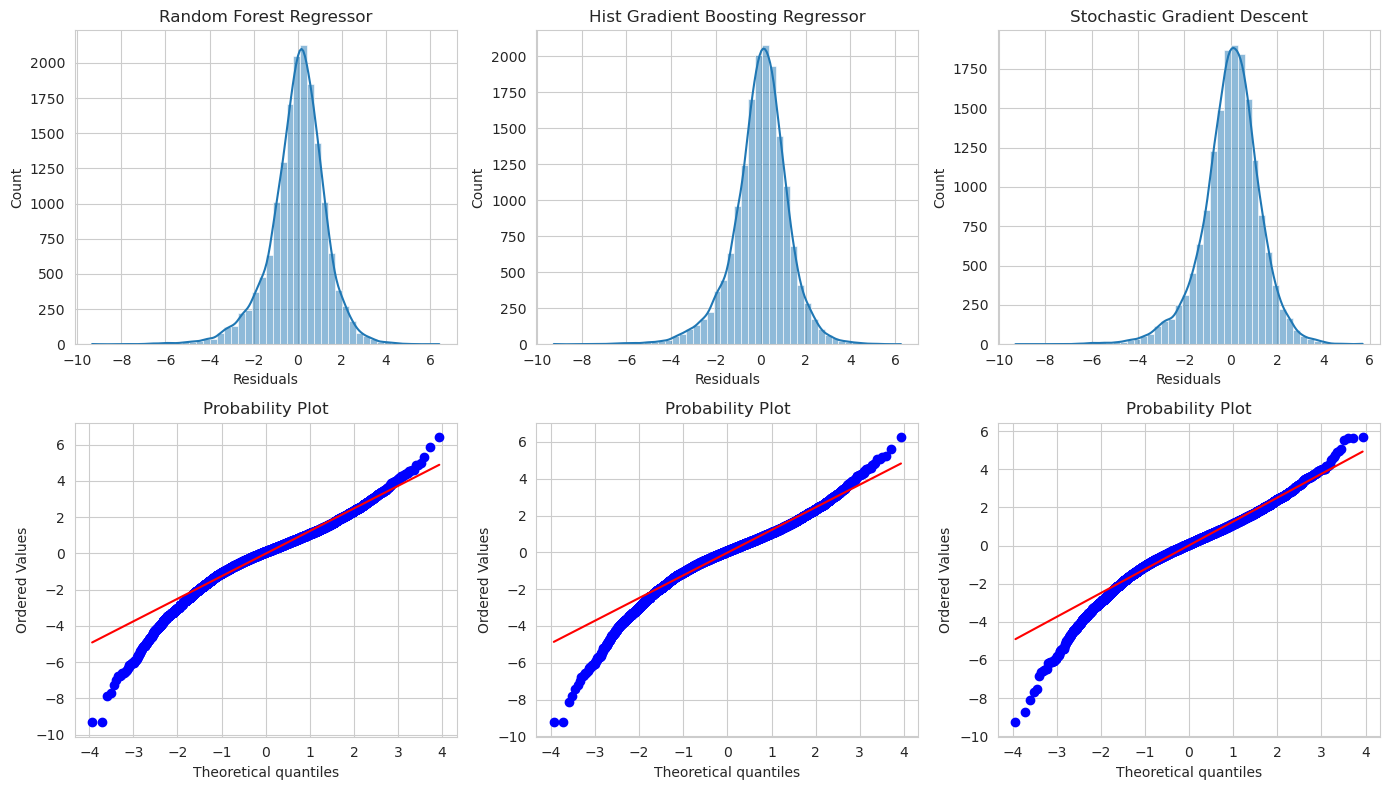

In [72]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, sharey=False, figsize=(14, 8))
for i, (name, model, _) in enumerate(models):
    # Calculate residuals
    residuals = y_test - model.predict(X_test)
    
    # Create a histogram
    sns.histplot(residuals, kde=True, bins=50, ax=axs[0, i])
    axs[0, i].set_xlabel('Residuals')
    axs[0, i].set_title(name)

    # Create QQ plot
    stats.probplot(residuals, plot=axs[1, i])

plt.tight_layout()
plt.show()

In [73]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# make a bootstrap sampler
n_splits = 10
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty dataframe to store the results
score_result_df = pd.DataFrame()
importance_df = pd.DataFrame()

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X_train, y_train), total=n_splits):
    # Get train part of bootstrap
    X_train_b = X_train.iloc[train_idx]
    y_train_b = y_train.iloc[train_idx]
    X_test_b = X_train.iloc[test_idx]
    y_test_b = y_train.iloc[test_idx]

    for name, model, func in models:
        # train all models
        model.fit(X_train_b, y_train_b)

        # Check how well the model is performing
        y_test_pred = model.predict(X_test_b)
        y_train_pred = model.predict(X_train_b)

        # Calculate R2
        score_test = r2_score(y_test_b, y_test_pred)
        score_train = r2_score(y_train_b, y_train_pred)
        # Calculate Mean Squared Error (MSE)
        mse_test = mean_squared_error(y_test_b, y_test_pred)
        mse_train = mean_squared_error(y_train_b, y_train_pred)

        # Save
        score_result_df = pd.concat(
            [score_result_df, pd.DataFrame({
                'r2': [score_test, score_train], 
                'mse':[mse_test, mse_train],
                'test': [True, False], 
                'model':[name, name]
            })], 
            axis=0
        )

        # Perform permutation importance
        result = permutation_importance(
            model, X_test_b, y_test_b, scoring='r2', n_repeats=1
        )
        temp = pd.DataFrame({
            'features': X_train_b.columns,
            'importance_mean': result['importances_mean'],
            'importance_std': result['importances_std'],
            'model':name
        })
        importance_df = pd.concat([importance_df, temp], axis=0)


# Save dataframes
score_result_df.to_csv(f"{base_path}/tables/score_results.csv", index=False)
importance_df.to_csv(f"{base_path}/tables/importance_results.csv", index=False)

100%|██████████| 10/10 [01:22<00:00,  8.22s/it]


In [91]:
from sklearn.inspection import partial_dependence
from sklearn.model_selection import StratifiedKFold

n_splits = 10
#custom_cv = StratifiedBootstrapSampler(n_bootstraps=n_splits, n_sample_train=40_000, n_sample_test=30_000, n_test=0.33)
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty list to store the results
df_results = pd.DataFrame(columns=["model_name", "feature_value", "partial_dependence"])
all_values = []
#features = [(v, 'Weather__tavg') for v in X_train.columns if v != 'Weather__tavg']

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X_train, y_train), total=n_splits):
    # Get train part of bootstrap
    X_train_b = X_train.iloc[train_idx]
    y_train_b = y_train.iloc[train_idx]
    X_test_b = X_train.iloc[test_idx]
    y_test_b = y_train.iloc[test_idx]

    for name, model, _ in models:
        # Fit the model
        model.fit(X_train_b, y_train_b)
        # Compute the partial dependence
        results = partial_dependence(model, X_train_b, 'Weather__tavg', kind='average', method='brute', grid_resolution=20)
        # Add each result to the list
        df_temp = pd.DataFrame({"model": name, 
                                "average": results['average'].squeeze(), 
                                "values": results['values'][0]})
        # append to the results DataFrame
        df_results = pd.concat([df_results, df_temp], axis=0)

100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


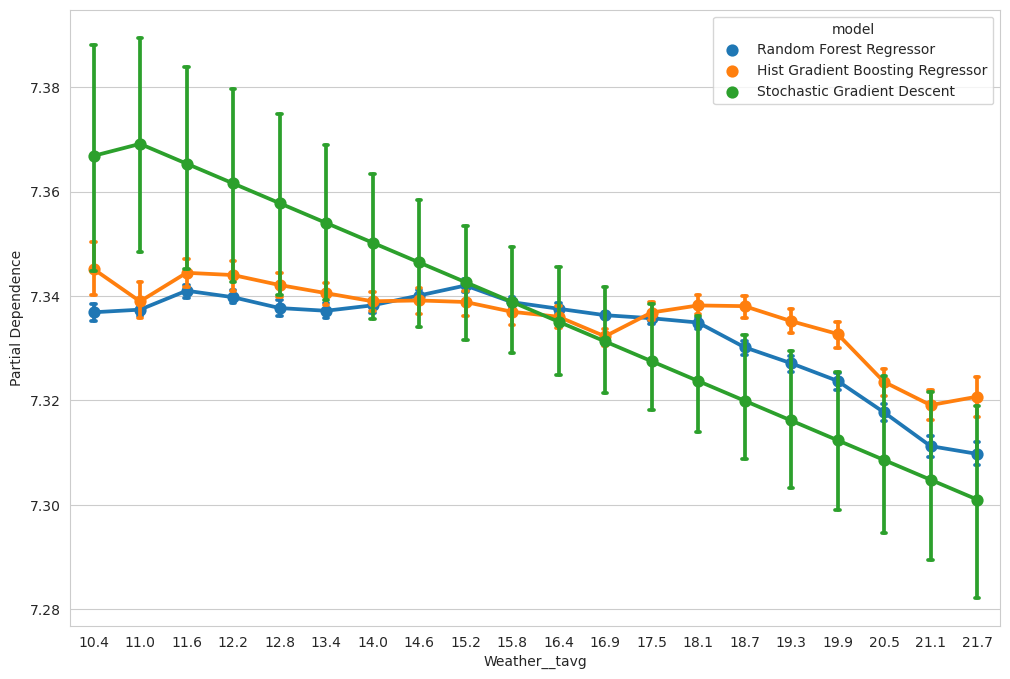

In [137]:
# Define number of bins
num_bins = 20

# Define bin edges
bin_edges = np.linspace(df_results['values'].min(), df_results['values'].max(), num_bins + 1)

# Create a new column 'bin' that assigns each 'values' entry to a bin
df_results['bin'] = pd.cut(df_results['values'], bins=bin_edges)

# Assign bin centers to 'bin_center' column
df_results['bin_center'] = df_results['bin'].apply(lambda x: x.mid)

temp = np.zeros((df_results.shape[0], 5)) # 5 weather variables
temp[:, -1] = df_results['bin_center'].values
bin_center_transformed = transformer.named_transformers_['Weather'].inverse_transform(temp)[:,-1]

df_results['bin_center'] = np.round(bin_center_transformed, 1)

# Plot with seaborn pointplot for each model
plt.figure(figsize=(12, 8))
sns.pointplot(data=df_results, x='bin_center', y='average', hue='model', join=True, capsize=.1)
plt.xlabel('Weather__tavg')
plt.ylabel('Partial Dependence')
plt.savefig(f'{base_path}/effect_temperature.pdf', dpi=300)